***************************
***************************
Preparing training and test sets...
Training set: 52428 elements 80% of data
Example: [([0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0], [1, 1, 0, 1, 0, 0, 0, 1]), ([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0], [1, 1, 0, 1, 0, 1, 1, 1])]
Test set: 13108 elements 20% of data
Example: [([1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0], [0, 1, 1, 0, 0, 0, 1, 0]), ([1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0], [0, 0, 1, 1, 1, 0, 1, 1])]
***************************
***************************
Learning...
epoch 0: 9948.507207532135 9948.4912109375
epoch 1: 2649.5027213335034 2649.50341796875
epoch 2: 1562.4169950274309 1562.4158935546875
epoch 3: 1109.2126767858824 1109.2138671875
epoch 4: 860.0207378580659 860.0198364257812
epoch 5: 702.3251338308934 702.3240966796875
epoch 6: 593.5383603645532 593.5364379882812
epoch 7: 513.9593043121256 513.9594116210938
epoch 8: 453.2165643600795 453.2164001464844
epoch 9: 405.3

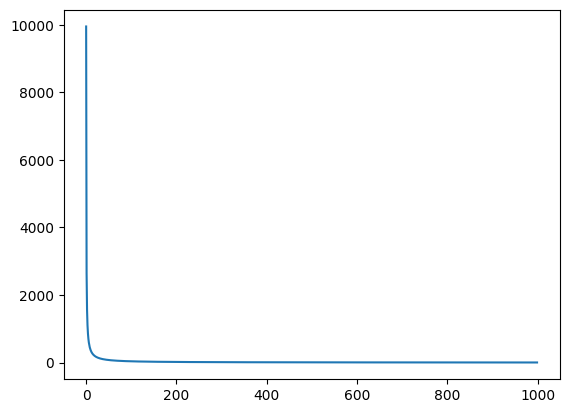

In [174]:
import typing as t
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline


THRESHOLD = 1e-10
NUM_BITS = 8
n_inputs = 2 * NUM_BITS + 1
n_outputs = NUM_BITS


w = np.random.randn(n_inputs, n_outputs) * 0.03
bias = np.random.randn(n_outputs, 1) * 0.001

wt = torch.tensor(w, requires_grad=True, dtype=torch.float32)
bt = torch.tensor(bias, requires_grad=True, dtype=torch.float32)
criterion = torch.nn.BCELoss()


print("***************************")
print("***************************")
print("Preparing training and test sets...")
all_inputs = []
for x1 in range(1 << NUM_BITS):
    for x2 in range(1 << NUM_BITS):
        for io, o in enumerate(["and"]):
            x = []
            for i in range(NUM_BITS):
                if (x1 & (1 << i)) != 0:
                    x.append(1)
                else:
                    x.append(0)
            for i in range(NUM_BITS):
                if (x2 & (1 << i)) != 0:
                    x.append(1)
                else:
                    x.append(0)
            x.append(io)
            y = eval(f"{x1} {o} {x2}")
            yf = []
            for i in range(NUM_BITS):
                if (y & (1 << i)) != 0:
                    yf.append(1)
                else:
                    yf.append(0)

            all_inputs.append((x, yf))

np.random.shuffle(all_inputs)
n1 = int(0.8 * len(all_inputs))

training_set = all_inputs[:n1]
test_set = all_inputs[n1:]
print(f"Training set: {len(training_set)} elements 80% of data\nExample: {training_set[:2]}")
print(f"Test set: {len(test_set)} elements 20% of data\nExample: {test_set[:2]}")

def forward(x: np.array) -> np.array:
    z = np.add(np.matmul(np.transpose(w), x), bias)
    y = 1.0 / (1.0 + np.exp(-z))
    y = np.clip(y, THRESHOLD, 1 - THRESHOLD)
    return y

def lossf(y: np.array, y_hat: np.array) -> np.float32:
    return -np.sum(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat)) / np.size(y)


def back(y: np.array, y_hat: np.array, x: np.array) -> t.Tuple[np.array, np.array]:
    """Returns derivatives for W and bias"""
    return np.transpose(y_hat - y) * np.array(x) / NUM_BITS, (y_hat - y) / NUM_BITS


def update_params(dw: np.array, db: np.array, lr: float) -> None:
    global w
    global bias
    w = w - lr * dw
    bias = bias - lr * db


LEARNING_RATE = 0.01
batch_size = 64
batch_start = 0
epoch_loss = []

print("***************************")
print("***************************")
print("Learning...")
for epoch in range(1000):
    sum_loss = 0
    sum_loss_t = 0

    for bs in range(0, len(training_set), batch_size):
        dw = None
        db = None
        first = True
        if wt.grad is not None:
            wt.grad.zero_()
            bt.grad.zero_()

        for sample_x, sample_y in training_set[batch_start:batch_start+batch_size]:
            xs = np.array(sample_x)[:, np.newaxis]
            ys = np.array(sample_y)[:, np.newaxis]
            y_hat = forward(xs)
            this_loss = lossf(ys, y_hat)
            sum_loss += this_loss
            cur_dw, cur_db = back(ys, y_hat, xs)
            if first:
                dw = cur_dw
                db = cur_db
                first = False
            else:
                dw += cur_dw
                db += cur_db
            outputs = torch.sigmoid(torch.t(wt) @ torch.from_numpy(xs.astype(np.float32)) + bt)
            loss = criterion(outputs, torch.from_numpy(ys.astype(np.float32)))
            sum_loss_t += loss
            loss.backward()

        update_params(dw, db, LEARNING_RATE)
        wt.data -= LEARNING_RATE * wt.grad
        bt.data -= LEARNING_RATE * bt.grad
    # if epoch == 0:
    print(f"epoch {epoch}: {sum_loss} {sum_loss_t}")
    epoch_loss.append(sum_loss)


def deconstruct(xs, ys, y_hat) -> t.Tuple[int, str, int, int, int, int]:
    x1 = 0
    x2 = 0
    y = 0
    ry = 0
    p2 = 1
    errors_in_bits = 0
    if xs[-1]:
        o = "and"
    else:
        o = "or"
    for i in range(NUM_BITS):
        if xs[i]:
            x1 += p2
        if xs[i + NUM_BITS]:
            x2 += p2
        turn1 = False
        turn2 = False
        if ys[i]:
            turn1 = True
            y += p2
        if y_hat[i] > 0.5:
            turn2 = True
            ry += p2
        if turn1 != turn2:
            errors_in_bits += 1
        p2 = 2 * p2
    return x1, o, x2, y, ry, errors_in_bits


print("***************************")
print("***************************")
print("Testing the network...")
count_wrong = 0
count_right = 0
count_wrong_t = 0
count_right_t = 0
errors_in_bits = [0] * (NUM_BITS + 1)
errors_in_bits_t = [0] * (NUM_BITS + 1)
for sample_x, sample_y in test_set:
    xs = np.array(sample_x)[:, np.newaxis]
    ys = np.array(sample_y)[:, np.newaxis]
    y_hat = forward(xs)
    outputs = torch.sigmoid(torch.t(wt) @ torch.from_numpy(xs.astype(np.float32)) + bt)

    y_hat = np.round(y_hat)
    output = torch.round(outputs)
    x1, o, x2, exp_y, real_y, bits = deconstruct(sample_x, sample_y, y_hat)
    errors_in_bits[bits] += 1
    if torch.equal(torch.from_numpy(np.array(sample_y).astype(np.float64)), torch.from_numpy(np.transpose(y_hat)).squeeze()):
        assert exp_y == real_y
        count_right += 1
    else:
        assert exp_y != real_y
        count_wrong += 1

    x1, o, x2, exp_y, real_y, bits = deconstruct(sample_x, sample_y, output)
    errors_in_bits_t[bits] += 1

    if torch.equal(torch.from_numpy(np.array(sample_y).astype(np.float64)), torch.transpose(output, 0, 1).squeeze()):
        count_right_t += 1
    else:
        count_wrong_t += 1

percent = round((100 * count_right) / (count_right + count_wrong))
print(f"Total wrong = {count_wrong} {count_wrong_t}")
print(f"Total right = {count_right} {count_right_t}")
print(f"{percent=}%")
print(f"{errors_in_bits=} {errors_in_bits_t=}")

plt.plot(epoch_loss)